In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas import read_pickle
from meteostat import Point, Hourly
from tqdm import tqdm
from datetime import datetime, timedelta

# plt.rcParams['font.family']='Times New Roman,Microsoft YaHei'# 设置字体族，中文为微软雅黑，英文为Times New Roman
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 设置数学公式字体为stix
plt.rcParams["text.usetex"] = False
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
dataiso = pd.read_pickle('isoprene_data.pkl')
datatempe = pd.read_pickle('temperature_data.pkl')

In [4]:
# 将'Date'列转换为日期时间格式
dataiso['Date'] = pd.to_datetime(dataiso['Date'])
datatempe['Date'] = pd.to_datetime(datatempe['Date'])

# 确保latitude和longitude为浮点数类型
dataiso['latitude'] = pd.to_numeric(dataiso['latitude'], errors='coerce')
dataiso['longitude'] = pd.to_numeric(dataiso['longitude'], errors='coerce')
datatempe['latitude'] = pd.to_numeric(datatempe['latitude'], errors='coerce')
datatempe['longitude'] = pd.to_numeric(datatempe['longitude'], errors='coerce')

# 解析'time_resolution'为Timedelta类型
def parse_time_resolution(res):
    try:
        delta = pd.to_timedelta(res)
    except Exception:
        if res.endswith('s'):
            seconds = int(res[:-1])
            delta = pd.Timedelta(seconds=seconds)
        elif res.endswith('min'):
            minutes = int(res[:-3])
            delta = pd.Timedelta(minutes=minutes)
        elif res.endswith('h'):
            hours = int(res[:-1])
            delta = pd.Timedelta(hours=hours)
        elif res.endswith('d'):
            days = int(res[:-1])
            delta = pd.Timedelta(days=days)
        else:
            delta = pd.NaT
    return delta

# 计算每条记录的时间区间
dataiso['time_resolution_timedelta'] = dataiso['time_resolution'].apply(parse_time_resolution)
datatempe['time_resolution_timedelta'] = datatempe['time_resolution'].apply(parse_time_resolution)

dataiso['start_time'] = dataiso['Date']
dataiso['end_time'] = dataiso['Date'] + dataiso['time_resolution_timedelta']
datatempe['start_time'] = datatempe['Date']
datatempe['end_time'] = datatempe['Date'] + datatempe['time_resolution_timedelta']

In [ ]:


# 初始化一个空的DataFrame来存储结果
matched_data = pd.DataFrame()

# 获取所有的station_id
station_ids = dataiso['station_id'].unique()

# 对每个station_id进行处理，添加进度条
for station_id in tqdm(station_ids, desc='Processing stations'):
    # 获取相同station_id的dataiso和datatempe数据
    iso_subset = dataiso[dataiso['station_id'] == station_id].copy()
    temp_subset = datatempe[datatempe['station_id'] == station_id].copy()
    
    # 按照时间排序，便于后续匹配
    iso_subset = iso_subset.sort_values('start_time').reset_index(drop=True)
    temp_subset = temp_subset.sort_values('start_time').reset_index(drop=True)
    
    # 如果有温度数据，进行匹配
    if not temp_subset.empty:
        # 为温度数据创建时间索引
        temp_subset.set_index(['start_time', 'end_time'], inplace=True)
        
        # 定义函数，匹配每个异戊二烯记录的温度数据
        def match_temperature(row):
            # 找到时间区间有重叠的温度数据
            overlap = temp_subset[
                (temp_subset.index.get_level_values('start_time') <= row['end_time']) & 
                (temp_subset.index.get_level_values('end_time') >= row['start_time'])
            ]
            if not overlap.empty:
                # 计算匹配到的温度数据的平均值
                avg_temp = overlap['temperature'].mean()
                return avg_temp
            else:
                return np.nan
        
        # 应用匹配函数
        iso_subset['temperature'] = iso_subset.apply(match_temperature, axis=1)
    else:
        # 如果没有温度数据，温度列设为NaN
        iso_subset['temperature'] = np.nan
    
    # 将结果添加到matched_data中
    matched_data = pd.concat([matched_data, iso_subset], ignore_index=True)

# 找出没有匹配到温度数据的记录
missing_temps = matched_data[matched_data['temperature'].isna()].copy()

# 对缺失温度数据的站点进行分组处理
missing_groups = missing_temps.groupby('station_id')

# 使用meteostat获取缺失的温度数据，并考虑时间分辨率
for station_id, group in tqdm(missing_groups, desc='Fetching Meteostat data'):
    lat = group['latitude'].iloc[0]
    lon = group['longitude'].iloc[0]
    
    # 获取该站点所有缺失数据的时间范围
    start_time = group['start_time'].min()
    end_time = group['end_time'].max()

    # 创建meteostat的Point对象
    location = Point(lat, lon)
    
    # 获取小时级别的温度数据
    try:
        data = Hourly(location, start_time, end_time)
        data = data.fetch()
    except Exception as e:
        print(f"Error fetching Meteostat data for station {station_id}: {e}")
        continue

    if not data.empty:
        # 将时间列转换为datetime，并设置为索引
        data.index = pd.to_datetime(data.index)
        data.sort_index(inplace=True)
    else:
        continue

    # 对于group中的每一行，按照时间分辨率匹配温度数据
    for idx, row in group.iterrows():
        # 获取当前记录的时间分辨率
        res = row['time_resolution_timedelta']
        # 获取当前记录的时间范围
        st = row['start_time']
        et = row['end_time']
        
        # 如果分辨率小于1小时，需要对温度数据进行插值
        if res < pd.Timedelta(hours=1):
            # 创建包含温度数据和时间索引的Series
            temp_series = data['temp']
            # 创建插值时间索引
            interp_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='1min')
            # 使用线性插值
            temp_interp = temp_series.reindex(interp_index)
            temp_interp = temp_interp.interpolate(method='time')
            # 在当前记录的时间范围内取平均温度
            mask = (temp_interp.index >= st) & (temp_interp.index <= et)
            avg_temp = temp_interp.loc[mask].mean()
            matched_data.loc[idx, 'temperature'] = avg_temp
        else:
            # 对于1小时或以上的分辨率，直接使用温度数据
            mask = (data.index >= st) & (data.index <= et)
            relevant_data = data.loc[mask]
            if not relevant_data.empty:
                avg_temp = relevant_data['temp'].mean()
                matched_data.loc[idx, 'temperature'] = avg_temp

# 检查是否还有未匹配到的温度数据
unmatched = matched_data[matched_data['temperature'].isna()]
print(f"Number of unmatched records: {len(unmatched)}")

# 对于仍未匹配到的，可以选择用平均值填充，或者保持为NaN
# matched_data['temperature'].fillna(matched_data['temperature'].mean(), inplace=True)

# 选择需要保留的列
columns_to_keep = [
    'Date', 'isoprene_ng_per_m3_amean', 'temperature', 'longitude', 'latitude',
    'monitoring_equipment', 'station_name', 'station_id', 'time_resolution'
]
matched_data = matched_data[columns_to_keep]

# 重命名列名，使其更清晰
matched_data = matched_data.rename(columns={
    'isoprene_ng_per_m3_amean': 'isoprene_amean'
})

In [ ]:
matched_data.columns=['Date', 'isoprene', 'temperature', 'longitude', 'latitude',
       'equipment', 'station', 'id','resolution']

In [ ]:
matched_data

In [ ]:
matched_data.to_pickle('dataebas.pkl')
matched_data.to_csv('dataebas.csv',index=False)

In [5]:
dataebas=pd.read_pickle('dataebas.pkl')

<Axes: >

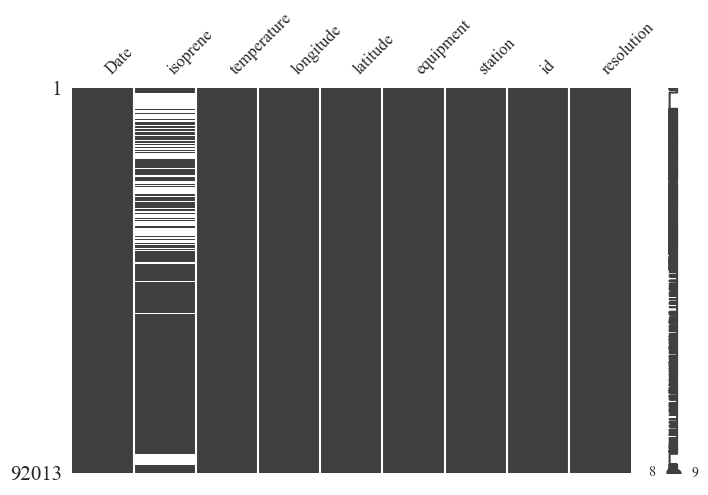

In [6]:
import missingno as msno
msno.matrix(dataebas, figsize=(8, 5), fontsize=12)

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from mssa.mssa import mSSA
col=['isoprene', 'temperature']
filled_data = dataebas.copy()

# 1. 识别非数值列
non_numeric_cols = filled_data.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"非数值列: {non_numeric_cols}")

# 2. 对非数值列进行编码
# 这里以标签编码为例，如果类别无序，可以考虑使用独热编码
label_encoders = {}
for col in non_numeric_cols:
    le = LabelEncoder()
    filled_data[col] = filled_data[col].astype(str)  # 确保所有数据为字符串类型
    filled_data[col] = le.fit_transform(filled_data[col])
    label_encoders[col] = le  # 保存编码器以备后用

# 如果需要使用独热编码，可以使用以下代码：
# filled_data = pd.get_dummies(filled_data, columns=non_numeric_cols, drop_first=True)

# 3. 选择所有数值列（包括编码后的非数值列）
numeric_cols = filled_data.select_dtypes(include=[np.number]).columns.tolist()
print(f"用于插补的数值列: {numeric_cols}")

# 4. 初始化 mSSA 模型
model = mSSA(fill_in_missing=False)

# 更新模型，使用所有数值列
model.update_model(filled_data[numeric_cols])

# 为每个日期时间创建一个整数映射
date_to_int = {date: i for i, date in enumerate(filled_data.index.unique())}

# 5. 对每列中的缺失值进行插值
for column in numeric_cols:
    missing_dates = filled_data[column][filled_data[column].isna()].index
    for date in missing_dates:
        int_index = date_to_int[date]  # 获取整数索引
        prediction = model.predict(column, int_index)["Mean Predictions"]  # 使用整数索引进行预测
        filled_data.at[date, column] = prediction.values[0]  # 更新数据集中的缺失值

# 如果你使用了独热编码，确保在插补后进行适当的处理

# 6. 恢复原始非数值列（如果需要）
for col, le in label_encoders.items():
    filled_data[col] = le.inverse_transform(filled_data[col].astype(int))

In [ ]:
msno.matrix(filled_data, figsize=(8, 5), fontsize=12)

In [ ]:
filled_data['isoprene'] = filled_data['isoprene'].clip(lower=0)

In [7]:
filled_data=pd.read_pickle('dataebasnona.pkl')

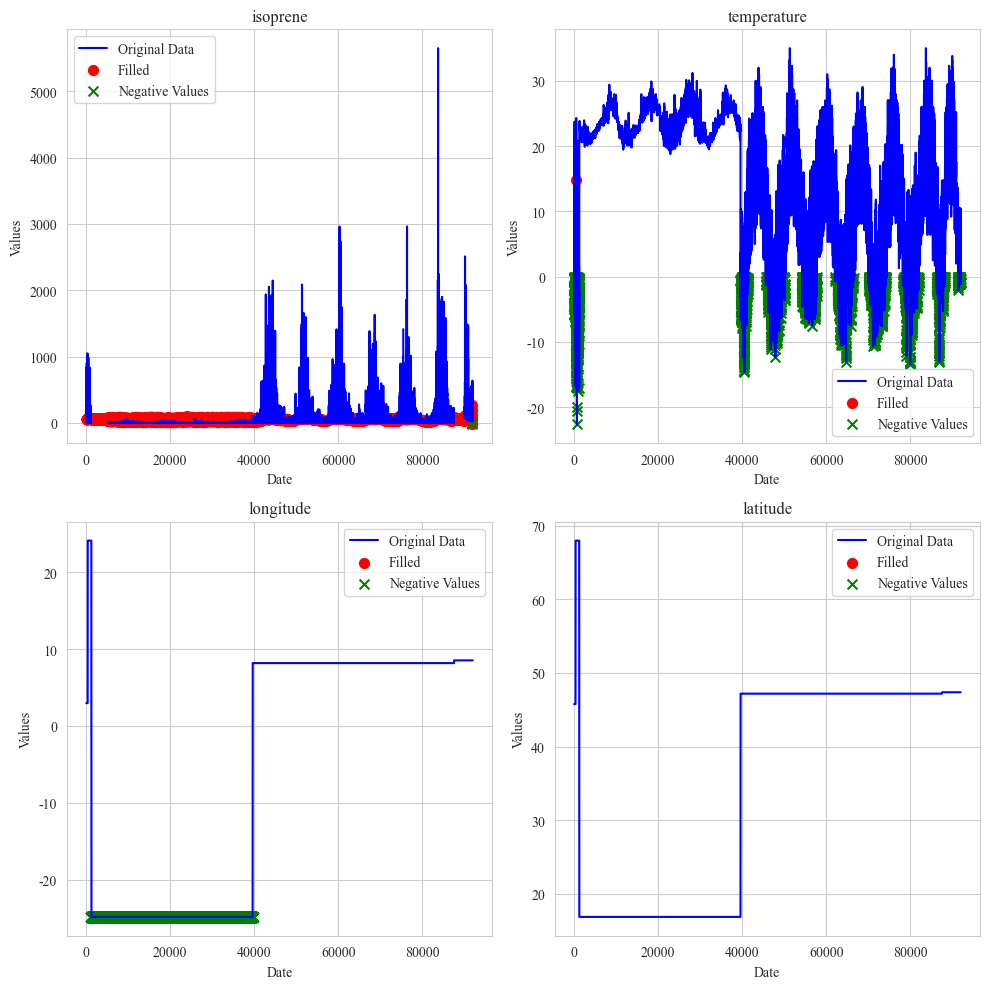

In [8]:
is_filled = filled_data.notna() & dataebas.isna()  # 用于对比哪里被填充了
# 计算需要多少行列来显示所有图
num_vars = filled_data.select_dtypes(include=[np.number]).shape[1]
num_cols = int(np.ceil(np.sqrt(num_vars)))
num_rows = int(np.ceil(num_vars / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
axes = axes.flatten()  # 扁平化 axes 数组方便索引

# 遍历每个数值变量，绘制数据并标出填充的位置
for i, column in enumerate(filled_data.select_dtypes(include=[np.number]).columns):
    ax = axes[i]
    # 绘制所有数据
    ax.plot(dataebas.index, dataebas[column], label='Original Data', linestyle='-', marker='', color='blue')
    
    # 特别标记填充的数据点
    filled_indices = filled_data.index[is_filled[column]]
    filled_values = filled_data[column][is_filled[column]]
    ax.scatter(filled_indices, filled_values, color='red', label='Filled', marker='o', s=50)  # 使用红色点标记填充的数据
    
    # 特别标记小于0的值
    negative_indices = filled_data.index[filled_data[column] < 0]
    negative_values = filled_data[column][filled_data[column] < 0]
    ax.scatter(negative_indices, negative_values, color='green', label='Negative Values', marker='x', s=50)  # 使用绿色叉号标记小于0的值

    ax.set_title(column)
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    ax.legend()
    ax.grid(True)

# 隐藏多余的轴
for i in range(len(filled_data.select_dtypes(include=[np.number]).columns), len(axes)):
    axes[i].axis('off')

fig.tight_layout()
plt.show()

In [ ]:
filled_data.to_pickle('dataebasnona.pkl')
filled_data.to_csv('dataebasnona.csv',index=False)

In [ ]:
plt.scatter(filled_data.temperature,filled_data.isoprene)

In [ ]:
import reverse_geocoder as rg
import pycountry_convert as pc

filled_data = dataebas.copy()

# 提取经纬度
coords = list(zip(filled_data['latitude'], filled_data['longitude']))

# 使用 reverse_geocoder 获取每个坐标的最近地理位置信息
results = rg.search(coords)  # 这将返回一个包含多个字典的列表

# 从结果中提取国家代码
filled_data['country_code'] = [result['cc'] for result in results]

# 定义一个函数将国家代码转换为大洲名称
def country_code_to_continent(country_code):
    try:
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return 'Unknown'

# 应用函数转换国家代码到大洲名称
filled_data['continent'] = filled_data['country_code'].apply(country_code_to_continent)

# 查看结果
print(filled_data[['latitude', 'longitude', 'country_code', 'continent']].head())

In [ ]:
np.unique(filled_data.continent)